In [50]:
## Peizhi Yan 2024 Copyright.

"""
In this demo we train a simple transformer network model for machine translation task
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time

from transformer_utils import PositionalEncoding, generate_mask, SimpleTokenizer
from transformer_lite import Transformer

device = 'cpu'

# define some hyperparameters
BATCH_SIZE = 16
MAX_LENGTH = 1000   # the maximum amount of "tokens" in a sequence
DIMENSION = 128     # the dimension of each "token" embedding
HIDDEN_DIM = 512    # the hidden dimension of the feed forward network (FFN)
ATTN_HEADS = 8      # the number of attention heads
NUM_BLOCKS = 6      # the number of transformer encoder/decoder blocks



### Positional Encoding

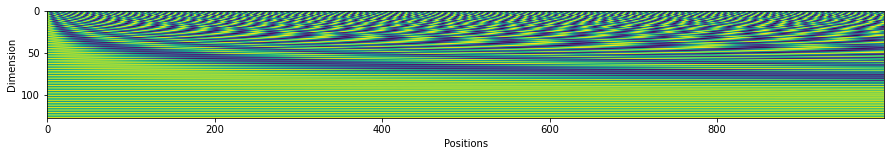

In [49]:
PE = PositionalEncoding(max_length=MAX_LENGTH, dim=DIMENSION)
x = torch.zeros([1, 1000, DIMENSION]).to(device) # batch = 1, sequence length = 100
x_pe = PE(x)
plt.figure(figsize=(15,5))
plt.imshow(x_pe[0].T)
plt.xlabel('Positions'); plt.ylabel('Dimension')
plt.show()


### Data, Tokenization, Embedding

Transformer 是一种深度学习架构，由 Google 的研究人员开发，基于 2017 年论文《Attention Is All You Need》中提出的多头注意力机制。文本被转换为称为 token 的数字表示，每个 token 通过从词嵌入表中查找转换为向量。在每一层，每个 token 随后通过并行多头注意力机制在上下文窗口范围内与其他（未屏蔽的）token 进行上下文化，从而放大关键 token 的信号并减弱不太重要的 token。
torch.Size([1, 1000, 128])


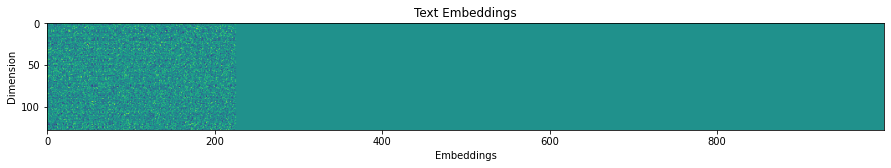

In [45]:
# source texts (in English)
src_texts = [
    "A transformer is a deep learning architecture that was developed by researchers at Google and is based on the multi-head attention mechanism, which was proposed in the 2017 paper \"Attention Is All You Need\". Text is converted to numerical representations called tokens, and each token is converted into a vector via lookup from a word embedding table. At each layer, each token is then contextualized within the scope of the context window with other (unmasked) tokens via a parallel multi-head attention mechanism, allowing the signal for key tokens to be amplified and less important tokens to be diminished.",
    "For many years, sequence modelling and generation was done by using plain recurrent neural networks (RNNs). A well-cited early example was the Elman network (1990). In theory, the information from one token can propagate arbitrarily far down the sequence, but in practice the vanishing-gradient problem leaves the model\'s state at the end of a long sentence without precise, extractable information about preceding tokens.",
    "These early seq2seq models had no attention mechanism, and the state vector is accessible only after the last word of the source text was processed. Although in theory such a vector retains the information about the whole original sentence, in practice the information is poorly preserved. This is because the input is processed sequentially by one recurrent network into a fixed-size output vector, which is then processed by another recurrent network into an output. If the input is long, then the output vector would not be able to contain all relevant information, degrading the output. As evidence, reversing the input sentence improved seq2seq translation."
]

# target texts (in Chinese)
tgt_texts = [
    "Transformer 是一种深度学习架构，由 Google 的研究人员开发，基于 2017 年论文《Attention Is All You Need》中提出的多头注意力机制。文本被转换为称为 token 的数字表示，每个 token 通过从词嵌入表中查找转换为向量。在每一层，每个 token 随后通过并行多头注意力机制在上下文窗口范围内与其他（未屏蔽的）token 进行上下文化，从而放大关键 token 的信号并减弱不太重要的 token。",
    "多年来，序列建模和生成都是使用普通的循环神经网络 (RNN) 完成的。一个被广泛引用的早期例子是 Elman 网络 (1990)。理论上，一个标记的信息可以沿着序列任意远地传播，但实际上，梯度消失问题导致模型在长句子末尾的状态没有关于前面标记的精确、可提取的信息。",
    "这些早期的 seq2seq 模型没有注意力机制，只有在处理完源文本的最后一个单词后才能访问状态向量。虽然理论上这样的向量保留了有关整个原始句子的信息，但实际上这些信息保存得并不好。这是因为输入由一个循环网络按顺序处理为固定大小的输出向量，然后由另一个循环网络处理为输出。如果输入很长，则输出向量将无法包含所有相关信息，从而降低输出质量。作为证据，反转输入句子可以改善 seq2seq 翻译。"
]

# combine both source and target texts to get a corpus
corpus = src_texts + tgt_texts

# create a simple tokenizer from the corpus
tokenizer = SimpleTokenizer(texts=corpus, max_length=MAX_LENGTH)

# test the tokenizer
indices = tokenizer.get_indices(text=tgt_texts[0])   # tokenize the text and get indices
tokens = tokenizer.get_tokens(indices=indices)       # convert the indices back to tokens
print(tokenizer.get_text_from_tokens(tokens=tokens)) # convert the list of tokens to text

# embedding
padding_idx = tokenizer.token_to_index['<EMPTY>']
num_embeddings = tokenizer.num_tokens # get the vocabulary size
token_embedding = torch.nn.Embedding(num_embeddings=num_embeddings, embedding_dim=DIMENSION, 
                                     padding_idx=padding_idx, device=device)

# test token embedding
embeddings = token_embedding(torch.LongTensor([indices]))
print(embeddings.shape)
plt.figure(figsize=(15,5))
plt.imshow(embeddings[0, :, :].detach().T)
plt.title('Text Embeddings'); plt.xlabel('Embeddings'); plt.ylabel('Dimension')
plt.show()

### Train

In [ ]:
# create the transformer model
transformer = Transformer(dim=DIMENSION, 
                          num_heads=ATTN_HEADS, 
                          num_blocks=NUM_BLOCKS, 
                          hidden_dim=HIDDEN_DIM, 
                          max_length=MAX_LENGTH).to(device)

# create the last classification layer
 tokenizer.num_tokens

